# Graphene

Graphene consists of carbon atoms in a 2d hexagonal configuration. Like WSe$_2$, graphene is a popular material for twisting and can be considered the cradle of twistronics since Macdonald's seminal publication. {cite}`continuum_model` Due to its simplicity and similarity to our research interest, it is a good example to showcase the application of Quantum Espresso (QE) {cite}`QE-2017` and Wannier90 (W90) {cite}`w90` to a 2d material. 

In [1]:
import plotly.graph_objects as go
import numpy as np
from myst_nb import glue
from moire.lattice import Lattice
from moire.plot import BandStructure
from moire.dft import DFT
import numpy as np

## Basic theory

A possible choice of lattice vectors for graphene is:

$$
    \vec a_1=\begin{pmatrix}1\\ 0\end{pmatrix}\text{ and } \vec a_2=\frac12\begin{pmatrix}-1\\ \sqrt{3}\end{pmatrix},    
$$ (iabdliba sajkb)

where length is in units of the lattice spacing $a$ between two carbon atoms, which is approximately 1.42 Å. {cite}`cooper2011experimental`

```{figure} logo.png
---
height: 0px
name: graphene_lattice
figclass: margin
---
Lattice structure of graphene.
```

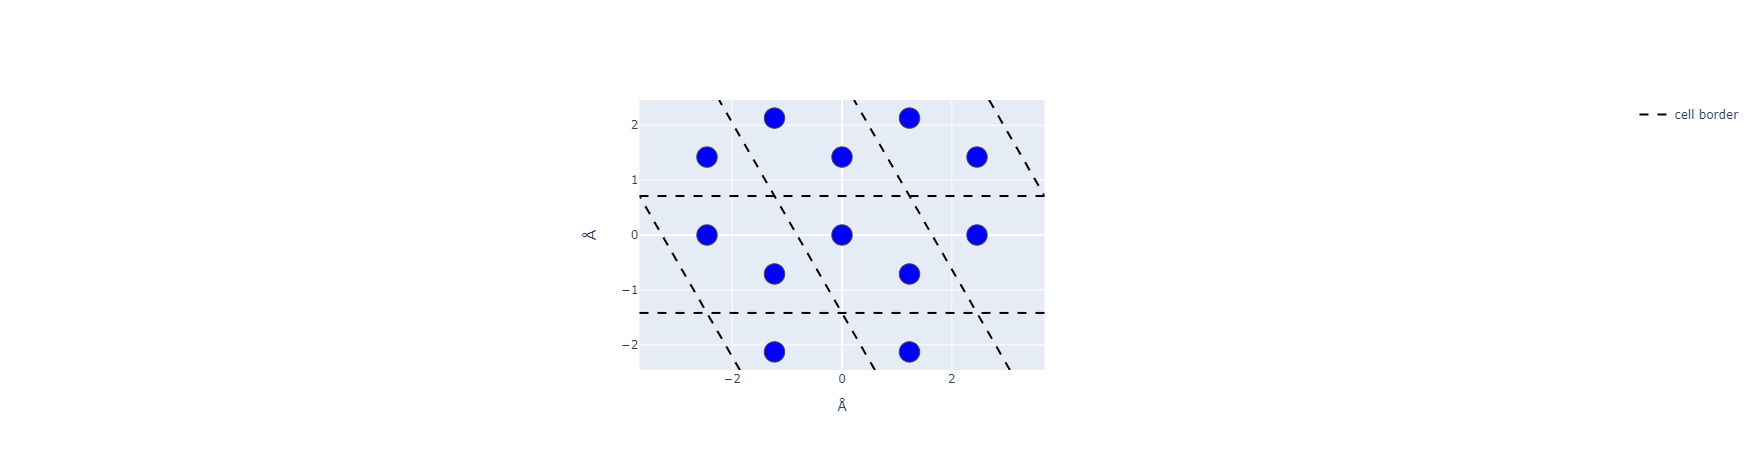

In [2]:
graphene_lat = Lattice(2.45951214)
C_dic = dict(name='C', color='blue', draw_radius=50, pseudo_potential='C.pbe-n-kjpaw_psl.1.0.0.UPF', weight=12.0107, projections=['pz'])
graphene_lat.set_atom(np.array((0, 0, 0)), C_dic)
graphene_lat.set_atom(np.array([0, 1.42, 0]), C_dic)
graphene_lat.plot(W=3, H=2, cell_attributes=dict(offset=np.array([2/3, -2/3]), line=dict(color='black', dash='dash'), name='cell border'))

In the case of sublattice symmetry the Hamiltonian writes:

$$
    H(\mathbf k) = \begin{pmatrix}
                        0&h_\mathbf k\\
                        h_\mathbf k^\dagger&0
                    \end{pmatrix},
$$ (TB Hamiltonian)

with:

$$
    h_\mathbf k = 1+\text e^{-i\mathbf k\cdot\vec a_1}+\text e^{i\mathbf k\cdot\vec a_2},
$$ (asbiasibd)

where energy is measured in units of the hopping parameter $t\approx 2.7$ eV between two carbon atoms {cite}`cooper2011experimental`.

```{figure} logo.png
---
height: 0px
name: graphene_bandstructure
figclass: margin
---
Tight-binding bandstructure of graphene from {eq}`TB Hamiltonian`. At the K point there is a Dirac point with linear dispersion.
```

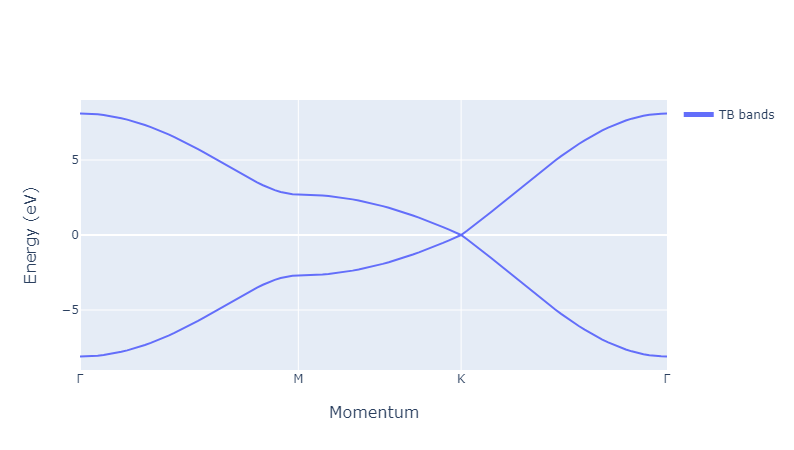

In [3]:
def H(k, **kwargs):
    a1 = np.array([1, 0])
    a2 = np.array([-1, np.sqrt(3)])/2
    b1 = np.array([1.000000,  0.577350])
    b2 =  np.array([0.000000,  1.154701])
    p = 2*np.pi*(k[0]*b1 + k[1]*b2)
    t = 2.7
    h = 1 + np.exp(-1j*np.dot(p, a1)) + np.exp(1j*np.dot(p, a2)) 
    return t*np.array([[0, h], [np.conj(h), 0]])

tb_bands = BandStructure()
tb_bands.set_k_path([(0, 0, 0), (0.5, 0, 0), (1/3, 1/3, 0), (0, 0, 0)], ["Γ", "M", "K", "Γ"], 100)
tb_bands.plot_from_H(H=H, name='TB bands')
tb_bands.fig

In {numref}`graphene_bandstructure` we plot the band structure for graphene for this tight-binding Hamiltonian. At the K point the dispersionbecomes linear and forms a Dirac point. 

## Quantum Espresso

Now we wish to recreate this bandstructure and Hamiltonian with a dft calculation. The first step here is a self-consistent field calculation which fixes the electron density for future band structure calculations.



In [4]:
work_dir = '/home/hidde/hidde/Unige/dft/graphene'
data_dir = '/home/hidde/hidde/Unige/Hidde-Dijkstra.github.io/dft_data/'
graphene = DFT('graphene', work_dir, data_dir)

control_dic = dict(pseudo_dir='../pseudo/')
system_dic = dict(occupations='smearing', degauss=0.015,  ecutwfc=45, nbnd=30)
graphene.prepare_qe({'&CONTROL': control_dic, '&SYSTEM': system_dic})
graphene.import_lattice(graphene_lat)
graphene.set_k_grid(8)
graphene.set_k_path([(0, 0, 0), (0.5, 0, 0), (1/3, 1/3, 0), (0, 0, 0)], ["Γ", "M", "K", "Γ"], 100)

In [5]:
write_qe = 0
run_scf = 0
run_bands = 0
run_nscf = 0
extract_projwfc = 0

if write_qe:
    for file_type in ['scf', 'nscf', 'bands']:
        graphene.write_qe(file_type)
if run_scf:
    graphene.run_qe('scf')
if run_bands:
    graphene.run_qe('bands')
    graphene.extract_nscf(task='bands')
if run_nscf:
    graphene.run_qe('nscf')
if extract_projwfc:
    graphene.extract_projwfc(proj_dir='projwfc/')

### SCF/NSCF/Bands input

::::{panels}
scf `&CONTROL` input
^^^
```
&CONTROL
  prefix = 'graphene'
  outdir = './out'
  verbosity = 'high'
  pseudo_dir = '../pseudo/'
  calculation = 'nscf'
/
```
---
Description
^^^
The `&CONTROL` card contains parameters controlling IO
* QE finds the required pseudopotentials in the `pseudo_dir` and stores them and all datafiles in the `outdir`. The `prefix` functions as a label for these files so that later calculations can find these specific files and reuse them. 
* `verbosity` sets the amount of information to be written to the output file.
* `calculation` type, in this case *scf*.
::::

::::{panels}
scf `&SYSTEM` input
^^^
```
&SYSTEM
  assume_isolated = '2D'
  ibrav = 4
  nat = 2
  ntyp = 1
  occupations = 'smearing'
  degauss = 0.015
  ecutwfc = 45
  nbnd = 30
  a = 2.45951214
  c = 32
/
```
---
Description
^^^
The `&SYSTEM` card sets parameters controlling lattice properties
* QE contains a number of preset lattices, with `ibrav` 4 we choose a triangular lattice with lattice vectors:
    1. $v_1 = a\begin{pmatrix}1&0&0\end{pmatrix}$  
    2. $v_2 = a\begin{pmatrix}-\frac12&\frac12\sqrt3&0\end{pmatrix}$
    3. $v_3=a\begin{pmatrix}0&0&\frac ca\end{pmatrix}$
    
    Here `a` and `c` controll the size of the lattice. For 2d lattices, like graphene, we use `assume_isolated` and a large value for `c` to make sure there is no periodicity in the z direction. Finally `nat` and `ntype` inform QE of the total number and the number of unique atoms in our unit cell.
* In the case of metals DFT can be unstable while integrating the Fermi surface. We prevent problems by setting `occupations` to `smearing` which smears the bands with a value set by `degauss`. 
* `ecutwfc` is a cut-off for the plane wave expansion of the wavefunctions. We can find appropriate cut-offs for each atom type at the [materialscloud](https://www.materialscloud.org/discover/sssp/table/efficiency). {cite}`SSSP`
* `nbnb` is the number of bands we wish QE to calculate. For a complete picture of the conduction bands it is important to set this parameter manually.
::::

::::{panels}
scf `&ELECTRONS` input
^^^
```
&ELECTRONS
/
```
---
Description
^^^
The `&ELECTRONS` card must be included for a scf calculation even though we use only the default parameters.
::::

::::{panels}
scf `ATOMIC` inputs
^^^
```
ATOMIC_SPECIES
  C    12.0107   'C.pbe-n-kjpaw_psl.1.0.0.UPF'
ATOMIC_POSITIONS angstrom
  C    0.0000000   0.0000000   0.0000000
  C    0.0000000   1.4200000   0.0000000
```
---
Description
^^^
* The `ATOMIC_SPECIES` card is a list of all atom types with their weight and pseudopotential files, non-relativistic pseudopotentials can also be found on the [materialscloud](https://www.materialscloud.org/discover/sssp/table/efficiency). {cite}`SSSP`
* The `ATOMIC_POSITIONS` card sets the unit of length and the positions of the atoms in the unit cell. We use angstrom as our unit of choice.
::::

::::{panels}
scf `K_POINTS` input
^^^
```
K_POINTS automatic
  9 9 1 1 1 1
```
---
Description
^^^
The `K_POINTS` card sets the k points at which QE calculates the wavefunctions and energies. The automatic option with input $n_1, n_2,n_3,s_1, s_2, s_3$ generates a Monkhorst-Pack grid of dimension $n_1\times n_2\times n_3$ with respective offsets $s_i=0\vee1$, corresponding to no offset or half a gridpoint offset.
::::

The *bands* and *nscf* files are identical save for the **calculation** and **K_POINTS** cards:

:::::{panels}
nscf `K_POINTS` input
^^^
::::{dropdown} K points list
```
K_POINTS crystal
64
  0.0000000   0.0000000   0.0000000 1
  0.0000000   0.1250000   0.0000000 1
  0.0000000   0.2500000   0.0000000 1
  0.0000000   0.3750000   0.0000000 1
  0.0000000   0.5000000   0.0000000 1
  0.0000000   0.6250000   0.0000000 1
  0.0000000   0.7500000   0.0000000 1
  0.0000000   0.8750000   0.0000000 1
  0.1250000   0.0000000   0.0000000 1
  0.1250000   0.1250000   0.0000000 1
  0.1250000   0.2500000   0.0000000 1
  0.1250000   0.3750000   0.0000000 1
  0.1250000   0.5000000   0.0000000 1
  0.1250000   0.6250000   0.0000000 1
  0.1250000   0.7500000   0.0000000 1
  0.1250000   0.8750000   0.0000000 1
  0.2500000   0.0000000   0.0000000 1
  0.2500000   0.1250000   0.0000000 1
  0.2500000   0.2500000   0.0000000 1
  0.2500000   0.3750000   0.0000000 1
  0.2500000   0.5000000   0.0000000 1
  0.2500000   0.6250000   0.0000000 1
  0.2500000   0.7500000   0.0000000 1
  0.2500000   0.8750000   0.0000000 1
  0.3750000   0.0000000   0.0000000 1
  0.3750000   0.1250000   0.0000000 1
  0.3750000   0.2500000   0.0000000 1
  0.3750000   0.3750000   0.0000000 1
  0.3750000   0.5000000   0.0000000 1
  0.3750000   0.6250000   0.0000000 1
  0.3750000   0.7500000   0.0000000 1
  0.3750000   0.8750000   0.0000000 1
  0.5000000   0.0000000   0.0000000 1
  0.5000000   0.1250000   0.0000000 1
  0.5000000   0.2500000   0.0000000 1
  0.5000000   0.3750000   0.0000000 1
  0.5000000   0.5000000   0.0000000 1
  0.5000000   0.6250000   0.0000000 1
  0.5000000   0.7500000   0.0000000 1
  0.5000000   0.8750000   0.0000000 1
  0.6250000   0.0000000   0.0000000 1
  0.6250000   0.1250000   0.0000000 1
  0.6250000   0.2500000   0.0000000 1
  0.6250000   0.3750000   0.0000000 1
  0.6250000   0.5000000   0.0000000 1
  0.6250000   0.6250000   0.0000000 1
  0.6250000   0.7500000   0.0000000 1
  0.6250000   0.8750000   0.0000000 1
  0.7500000   0.0000000   0.0000000 1
  0.7500000   0.1250000   0.0000000 1
  0.7500000   0.2500000   0.0000000 1
  0.7500000   0.3750000   0.0000000 1
  0.7500000   0.5000000   0.0000000 1
  0.7500000   0.6250000   0.0000000 1
  0.7500000   0.7500000   0.0000000 1
  0.7500000   0.8750000   0.0000000 1
  0.8750000   0.0000000   0.0000000 1
  0.8750000   0.1250000   0.0000000 1
  0.8750000   0.2500000   0.0000000 1
  0.8750000   0.3750000   0.0000000 1
  0.8750000   0.5000000   0.0000000 1
  0.8750000   0.6250000   0.0000000 1
  0.8750000   0.7500000   0.0000000 1
  0.8750000   0.8750000   0.0000000 1
```
::::
---
Description
^^^
The `K_points` card is list of points along a path in k space for `bands` and a grid for `nscf`, preceded by the numbe rof points, in this case 64. Here we replace `automatic` with `crystal` which reads the k points in crystal coordinates (relative to the reciprocal lattice vectors). The fourth number is the relative weight of the k point.
:::::

### Bands output

The main output we directly care about is the bands output which leads a summary of the input arguments and the symmetries of the lattice. Since we define all K points explicitly these will not be used by QE. When we choose an automatic grid QE significantly decreases the points it needs to evaluate. Near the end of the file all k points and energies of the bands are printed.

::::{panels}
bands output
^^^
```
          k = 0.0000 0.0000 0.0000 (  5649 PWs)   bands (ev):

   -23.8181 -11.9014  -7.2766  -7.2766  -1.3477  -0.9995  -0.7246  -0.5157
    -0.0219   0.2830   1.0299   1.4288   2.4049   2.9177   4.0662   4.1555
     4.1555   4.7234   6.0004   6.8461   7.2901   8.1773   8.4570   9.2604
    10.5975  11.9548  13.2678  14.9152  16.2216  18.1415
```
---
Description
^^^
The first k point evaluated by QE and all corresponding energies in eV. 
::::

```{figure} logo.png
---
height: 0px
name: graphene_qe_bandstructure
figclass: margin
---
QE bandstructure of graphene with the bands from the TB Hamiltonian included, translated so that the K points overlap. The TB bands match the valence bands exceptionally well.
```

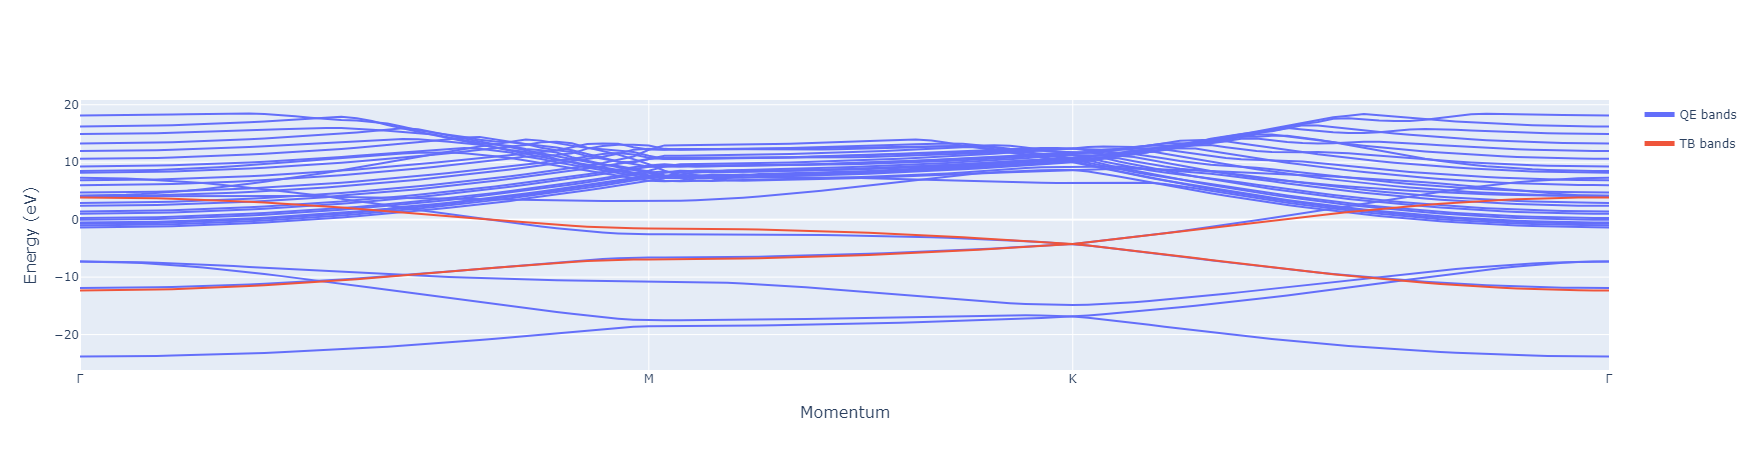

In [6]:
def H0(k):
    return H(k)-4.2244*np.eye(2)

band_plot = graphene.plot_qe_bands(reset_color=True)
band_plot.plot_from_H(H=H0, name='TB bands')
band_plot.fig

In {numref}`graphene_qe_bandstructure` we plot the QE bands together with the TB bands from {eq}`TB Hamiltonian`. The model works quite well for the valence part of the QE bands. Ostensibly we require NNN hoppings and beyond to capture the conduction band component more accurately.

### Projwfc input

Before we start the wannierization process we need to know which bands we want to wannierize and which atomic orbital contribute to these bands. QE offers a program called projwfc (project wavefunctions) which does exactly this. 

::::{panels}
projwfc input
^^^
```
&PROJWFC
  prefix = 'graphene'
  outdir = '../out'
  DeltaE = 0.05
/
```
---
Description
^^^
The `PROJWFC` card is the only card for projwfc source files. The `prefix` and `outdir` should match the project. `DeltaE` is the step size for the dos calculation of the projected orbitals, which we do not need but must be set for the program to work.
::::

### Projwfc output

::::{panels}
PROJWFC output: states
^^^
```
     state #   1: atom   1 (C  ), wfc  1 (l=0 m= 1)
     state #   2: atom   1 (C  ), wfc  2 (l=1 m= 1)
     state #   3: atom   1 (C  ), wfc  2 (l=1 m= 2)
     state #   4: atom   1 (C  ), wfc  2 (l=1 m= 3)
     state #   5: atom   2 (C  ), wfc  1 (l=0 m= 1)
     state #   6: atom   2 (C  ), wfc  2 (l=1 m= 1)
     state #   7: atom   2 (C  ), wfc  2 (l=1 m= 2)
     state #   8: atom   2 (C  ), wfc  2 (l=1 m= 3)
```
---
Description
^^^
The projwfc output file contains a list of the projected atomic orbitals. For graphene we have two sites: `atom 1` and `atom 2`, two atomic orbital types: s-orbitals with azimuthal quantum number `l=0` (`wfc 1`) and p-orbitals with azimuthal quantum number `l=1` (`wfc 2`). For `l=1` there are three different possibilities for the magnetic quantum number $m_l=-1, 0, 1$. For a spinless bandstructure this quantum number is reformulated to `m=1` for the p$_z$ orbital, `m=2` for the p$_x$ orbital and `m=3` for the p$_y$ orbital. In total we have 8 orbitals.
::::

The second part of the projwfc output file list the contribution of each state to each band at each k points.

::::{panels}
PROJWFC output: states
^^^
```
 k =   0.0000000000  0.0000000000  0.0000000000
==== e(   1) =   -23.81812 eV ==== 
     psi = 0.492*[#   1]+0.492*[#   5]+
    |psi|^2 = 0.984
==== e(   2) =   -11.90144 eV ==== 
     psi = 0.473*[#   2]+0.473*[#   6]+
    |psi|^2 = 0.946
==== e(   3) =    -7.27665 eV ==== 
     psi = 0.249*[#   3]+0.249*[#   4]+0.249*[#   7]+0.249*[#   8]+
    |psi|^2 = 0.997
==== e(   4) =    -7.27665 eV ==== 
     psi = 0.249*[#   3]+0.249*[#   4]+0.249*[#   7]+0.249*[#   8]+
    |psi|^2 = 0.997
==== e(   5) =    -1.34766 eV ==== 
     psi = 0.002*[#   1]+0.002*[#   5]+
    |psi|^2 = 0.005
==== e(   6) =    -0.99950 eV ==== 
     psi = 0.004*[#   2]+0.004*[#   6]+
    |psi|^2 = 0.007
```
---
Description
^^^
The contribution of the eight states to the first 6 bands at the first k point. If we write the wavefunction as $\Psi = \sum\alpha_i\psi_i$ then the number before each state corresponds to $|\alpha_i|^2$. We see that for bands 5 and 6 `|psi|^2` is not even close to 1. This tells us that this band can not be described with these 8 states. The leftover plus at the end of the line is just a for loop artifact which can be ignored.
::::


In tandem with the projected orbitals we wrote a small script to untangle the bands so we can separate the future Wannier bands from the other conduction bands.

```{figure} logo.png
---
height: 0px
name: graphene_projwfc
figclass: margin
---
QE bandstructure of graphene with possible Wannier bands in solid black, left over bands are dotted.
```

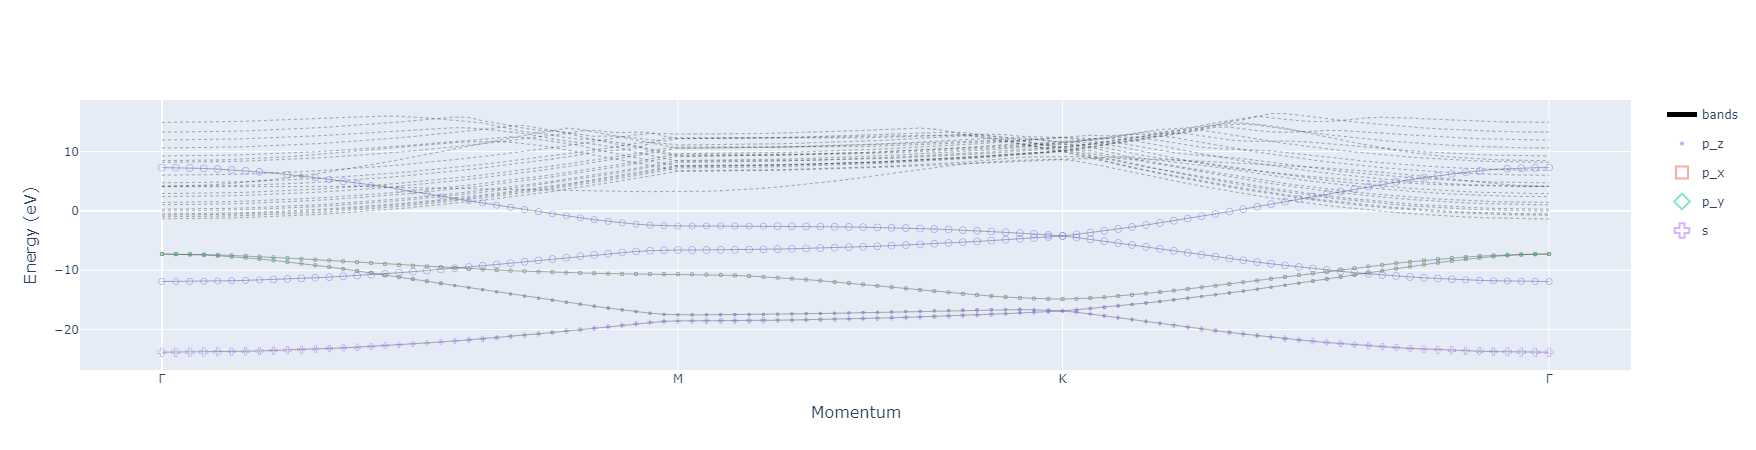

In [7]:
orb_args = dict(orbitals=[dict(l=1, m=1), dict(l=1, m=2), dict(l=1, m=3), dict(l=0)])
graphene.plot_wfc(
    dis_min=-20,
    dis_max= -1.5, 
    k_tags=['Γ', 'M', 'K', 'Γ'], 
    k_list=[(0, 0, 0), (0.5, 0, 0), (1/3, 1/3, 0), (0, 0, 0)], 
    N_k=100,
    legend=dict(
        args=orb_args, 
        tags=['p_z', 'p_x', 'p_y', 's'], autocolor=True, autosymbol=True), 
    size=7, reset_color=True, ε_margin=10, α=0.7, print_N_wan=False)

## Wannier90

Next up is the wannierization of the two bands forming the Dirac cone. From{numref}`graphene_projwfc` we learn that only the p$_z$ orbitals contribute and that these bands extend far into the valence bands. To untangle these bands we need to make sure that takes all these bands into account. That is why we have set `nbnb` quite high for the `nscf` calculation so that QE produces the whole band. It is essential that the `nscf` calculation is run after a `bands` calculation using the same `outdir` for both as they overwrite each other's wavefunctions.

### W90 input

::::{panels}
W90 general input
^^^
```
guiding_centres = true
write_hr = true
wannier_plot = true
bands_plot = true
num_bands = 30
num_wann = 2
num_iter = 2000
wannier_plot_supercell = 3, 3, 1
```
---
Description
^^^
* `guiding_centres` tells W90 to use the projection (orbital) centres as the guiding centres for the Wannier orbitals
* `write_hr` tells W90 to write the hopping energies to a file, `wannier_plot` does the same for the Wannier orbitals. We use `wannier_plot_supercell = 3, 3, 1` to prevent Wannier orbitals to be cut off at the edges of the unit cell (extends the unit cell in the xy plane).
* `num_bands` describes the number of bands coming from the QE `nscf` calculation and `num_wann` the number of Wannier bands to project to.
* `num_iter` is the maximum number of iterations W90 is allowed to execute while minimizing the spread of the Wannier orbitals. If the spread is not satisfactory after the given number of iteration, add `restart=wannierise` to the input and W90 will continue where it left off.
::::


::::{panels}
W90 disentanglement input
^^^
```
dis_win_min = -12
dis_win_max = 8
dis_froz_min = -7
dis_froz_max = -1.5
dis_num_iter = 500
```
---
Description
^^^
These arguments set the parameters with which to disentangle the #`num_bands` to extract #`num_wann` bands. 

* The choice of `dis_froz_min` and `dis_froz_max` is the most important challenge of any W90 calculation. Together they set a window in which only the Wannier bands are present. The window should then be chosen as large as possible for better convergence. In {numref}`graphene_projwfc` we clearly see that between energies -7 eV and -1.5 eV only the Dirac bands are present, an easy choice for the disentanglement window. 
* The `dis_min` and `dis_max` arguments also form a window which should contain all Wannier orbitals and be as small as possible. {numref}`graphene_projwfc` indicates that a good choice is the window from -12 eV to 8 eV.
* `dis_num_iter` is de maximum amount of disentanglement iterations to perform. 
::::

::::{panels}
W90 lattice input
^^^
```
begin unit_cell_cart
  2.4595121   0.0000000   0.0000000
  -1.229756   2.1299999   0.0000000
  0.0000000   0.0000000   32.000000
end unit_cell_cart

Begin atoms_cart
ang
  C   0.0000000   0.0000000   0.0000000
  C   0.0000000   1.4200000   0.0000000
End atoms_cart

Begin projections
  C:  pz
End projections
```
---
Description
^^^
These arguments set the lattice and projections.

* `unit_cell_cart` lists the three lattice vectors in Angstrom.
* `atoms_cart` lists all atoms and their location in the unit cell.
* `projections` sets the initial guess for the Wannier orbitals as some mix of atomic orbitals. {numref}`graphene_projwfc` tells us that a good guess for the Dirac bands are the p$_z$ orbitals
::::


In [8]:
graphene.prepare_w90(dict(wannier_plot=True, num_wann=2, num_iter=2000))
graphene.set_w90_window(-12, 8, -7, -1.5, 500)

write_w90 = 0
run_w90 = 0
pp = 0
extract_orbitals = 0

if write_w90:
    graphene.write_w90()
if run_w90:
    graphene.run_w90(pp=pp)
    graphene.extract_w90()
if extract_orbitals:
    graphene.extract_orbitals('orbitals')

In [1]:
bs = graphene.plot_w90_bands()
bs.plot_from_H(H=H0, name='TB bands')
bs.plot_from_H(H=graphene.create_H(1.5), name='NN', print_N=False)
bs.plot_from_H(H=graphene.create_H(2.5), name='NNN', print_N=False)
bs.fig

NameError: name 'graphene' is not defined

In [11]:
graphene.plot_wannier('orbitals')